# DeepFashion Dataset
a notebook to explore the DeepFashion dataset in order to prepare a `Dataset` class and `Dataloader` 

Note that the data used for Text2Human project was processed vs the original DeepFashion-MultiModal thus we might want to use this dataset, as the images are already aligned


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
%matplotlib inline

In [2]:
!which python

/opt/conda/bin/python


In [5]:
! ls /workspace/Data/DeepFashion

'Category and Attribute Prediction Benchmark'
'Consumer-to-shop Clothes Retrieval Benchmark'
'Fashion Landmark Detection Benchmark'
'Fashion Synthesis Benchmark'
'In-shop Clothes Retrieval Benchmark'


In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Explore the images

## CelebA
this is the dataset considered as a baseline

In [3]:
clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'
imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

202599

In [4]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

True

Lets check the alignment by displaying the average of the images

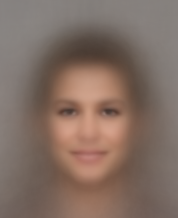

In [33]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [34]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

## DeepFashion-MultiModal

In [ ]:
dfmm_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion-MultiModal/images'
imgs_filenames=os.listdir(dfmm_path)
len(imgs_filenames)


In [ ]:
imsz = [Image.open(os.path.join(dfmm_path,im)).size for im in imgs_filenames]
imgs = [Image.open(os.path.join(dfmm_path,im)) for im in imgs_filenames[100:110]]
# plt.imshow(img)

In [ ]:
np.all([s==imsz[0] for s in imsz])

In [ ]:
[s for s in imsz if s != imsz[0] ]

In [ ]:
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df.head()

In [ ]:
df.new_col.value_counts()

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
[im.size for im in imgs]

## Text2Human Processed dataset

In [ ]:
t2h_path = '/home/guy/sd1tb/datasets/deep_fashion/Text2Human/train_images'
imgs_filenames=os.listdir(t2h_path)
len(imgs_filenames)


In [ ]:
# extract image sizes and make sure they all at sime size
t2h_imsz = [Image.open(os.path.join(t2h_path,im)).size for im in imgs_filenames]
np.all([s==t2h_imsz[0] for s in t2h_imsz])

In [ ]:
t2h_imsz[0]

In [ ]:
imgs = [Image.open(os.path.join(t2h_path,im)) for im in imgs_filenames[:20]]


In [ ]:
size

In [ ]:
size=(256,256)
imgs_tn=imgs.copy()
[i.thumbnail(size) for i in imgs_tn]
image_grid(imgs_tn,4,5)

## DeepFashion dataset


### Fashion Synthesis Benchmark

In [ ]:
import h5py

In [ ]:
f = h5py.File('/home/guy/sd1tb/datasets/deep_fashion/G2.h5','r')
for k in f.keys():
    print(k)
    print(type(f[k]))

In [ ]:
b=f['b_']
for k in b.keys():
    print(k)

### Other Benchmarks

In [35]:
from glob import glob as Glob

In [36]:
benchmarks = [os.path.basename(bm) for bm in Glob('/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/*') if os.path.isdir(bm)]
benchmarks

['Category and Attribute Prediction Benchmark',
 'Fashion Synthesis Benchmark',
 'Fashion Landmark Detection Benchmark',
 'In-shop Clothes Retrieval Benchmark',
 'Consumer-to-shop Clothes Retrieval Benchmark']

In [37]:
img_fn=[i for i in Glob(f'/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/{benchmarks[3]}/Img/**/*.jpg',recursive=True)] # if 'front' in i]
len(img_fn)

52712

In [ ]:
imsz = [Image.open(im).size for im in img_fn]
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df['img_fn']=img_fn
df['new_col'].value_counts()

In [ ]:
# display the smallest image in the dataset
# img=Image.open(df.loc[df['x']==70,'img_fn'])
img=Image.open(df.loc[df['x']==df['x'].min(),'img_fn'].values[0])
print(img.size)
img

In [ ]:
df['y'].hist()

In [ ]:
df['x'].sort_values

In [ ]:
imgs=[Image.open(m) for m in img_fn[200:225]]
image_grid(imgs,5,5)


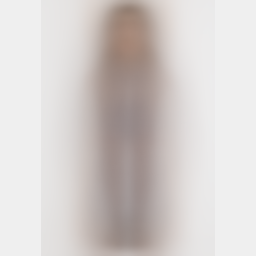

In [41]:
img_indxs = [i for i in range(20000)]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

OK, the average image looks poor. it would be interesting to see whether the VAE can capture the variance in the dataset and get farther from the average image.

OK, lets start with the `In-Shop-Clothes-Retreival-Benchmark` dataset and try to find a disentangled representation using VAEs

# Preparing the dataset
The goal is to prepare a dataset class and dataloader that we can use to train the VAE.
we can use the code from the `Text2Human` repo


In [4]:
import os.path

import numpy as np
import torch
import torch.utils.data as data
from torchvision.io import read_image

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torchvision.io as tvio 
from torchvision import transforms as T

In [ ]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

# todo : look at how the CelebA returns the batch and make sure the below is compatible

class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read(fpath, 1)
        return img

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes
